# Testing vegetation fractional cover

### Setup
- venv: /g/data/xe2/John/geospatenv
- module: tensorflow/2.15.0

### Purpose
Testing out code produced by Scarth et al for estimating veg cover fractions from Sentinel data. See here: https://zenodo.org/records/7008343#.Y3r0jfFByJE

The function takes in an array of 7-band sentinel data, and runs it through one of 4 tensor models made by testing Sentinel data against Landsat-based predictions. The landsat-based model was trained/tested on field data, but the sentinel-based model was not. Therefore, there could be weird effects that come into play. Not sure how to think about accuracy of the veg fractions. All we can do now is eyeball it...



In [1]:
# all these might not be necesary:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib
import rioxarray
from shapely.geometry import mapping

%matplotlib inline

import cv2 
from matplotlib.gridspec import GridSpec
from dea_tools.plotting import display_map, rgb, xr_animation
import skimage

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.clustering import KShape, KernelKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

from IPython.display import Image
from IPython.core.display import Video

import pickle
import os
import shutil

import ffmpeg # REQUIRES a module load ffmpeg/4.3.1 (in jupyterlab, must do when setting up sesh)


In [2]:
import tensorflow as tf
from fractionalcover3 import unmix_fractional_cover # this works
from fractionalcover3 import data # this now works


2024-08-09 12:09:15.359832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 12:09:15.360159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 12:09:15.425683: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Test the function for estimating fractions from example reflectance data.
# which 7 bands do these represent>???
inref = np.array([562, 825, 1088, 2056, 2951, 2187]) * 0.0001
inref.shape = (6, 1, 1)

print(inref)

for i in [1, 2, 3, 4]:
    fractions = unmix_fractional_cover(inref,
    fc_model=data.get_model(n = i))
    print('n = ', i)
    print(fractions)
    print('--------')

print(fractions.shape)

[[[0.0562]]

 [[0.0825]]

 [[0.1088]]

 [[0.2056]]

 [[0.2951]]

 [[0.2187]]]
n =  1
[[[0.19195895]]

 [[0.21914724]]

 [[0.58510524]]]
--------
n =  2
[[[0.12142971]]

 [[0.23126283]]

 [[0.6459607 ]]]
--------
n =  3
[[[0.16790634]]

 [[0.24358413]]

 [[0.5932151 ]]]
--------
n =  4
[[[0.13551159]]

 [[0.2181125 ]]

 [[0.64592296]]]
--------
(3, 1, 1)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
stub = 'test'
outdir = "/g/data/xe2/John/Data/PadSeg/" # best if output is stored in gdata


with open(outdir+stub+'_ds2.pkl', 'rb') as handle:
    ds = pickle.load(handle)

print(ds)

<xarray.Dataset>
Dimensions:                     (time: 8, y: 210, x: 194)
Coordinates:
  * time                        (time) datetime64[ns] 2020-01-10T00:06:26.298...
  * y                           (y) float64 -4.228e+06 -4.228e+06 ... -4.23e+06
  * x                           (x) float64 1.438e+07 1.438e+07 ... 1.438e+07
    spatial_ref                 int32 6933
Data variables: (12/40)
    nbart_coastal_aerosol       (time, y, x) float32 734.0 734.0 ... 290.0 290.0
    nbart_blue                  (time, y, x) float32 916.0 930.0 ... 196.0 198.0
    nbart_green                 (time, y, x) float32 1.276e+03 ... 294.0
    nbart_red                   (time, y, x) float32 1.885e+03 ... 179.0
    nbart_red_edge_1            (time, y, x) float32 2.219e+03 ... 184.0
    nbart_red_edge_2            (time, y, x) float32 2.425e+03 ... 213.0
    ...                          ...
    NDWI                        (time, y, x) float32 -0.3932 -0.3843 ... 0.09701
    MNDWI                       (t

In [48]:
def calculate_fractional_cover(ds, band_names, i):
    """
    Calculate the fractional cover using specified bands from an xarray Dataset.

    Parameters:
    ds (xarray.Dataset): The input xarray Dataset containing the satellite data.
    band_names (list): A list of 6 band names to use for the calculation.
    i (int): The integer specifying which pretrained model to use.

    Returns:
    numpy.ndarray: The output array with fractional cover (time, bands, x, y).
    """
    # Check if the number of band names is exactly 6
    if len(band_names) != 6:
        raise ValueError("Exactly 6 band names must be provided")
    
    # Extract the specified bands and stack them into a numpy array with shape (time, bands, x, y)
    inref = np.stack([ds[band].values for band in band_names], axis=1)
    print(inref.shape)  # This should now be (time, bands, x, y)

    #inref = inref * 0.0001 # if not applying the correcion factors below

    # Array for correction factors 
    # This is taken from here: https://github.com/petescarth/fractionalcover/blob/main/notebooks/ApplyModel.ipynb
    # and described in a paper by Neil Floodfor taking Landsat to Sentinel 2 reflectance (and visa versa).
    correction_factors = np.array([0.9551, 1.0582, 0.9871, 1.0187, 0.9528, 0.9688]) + \
                         np.array([-0.0022, 0.0031, 0.0064, 0.012, 0.0079, -0.0042])

    # Apply correction factors using broadcasting
    inref = inref * correction_factors[:, np.newaxis, np.newaxis]

    # Initialize an array to store the fractional cover results
    fractions = np.empty((inref.shape[0], 3, inref.shape[2], inref.shape[3]))

    # Loop over each time slice and apply the unmix_fractional_cover function
    for t in range(inref.shape[0]):
        fractions[t] = unmix_fractional_cover(inref[t], fc_model=data.get_model(n=i))
    
    return fractions


In [44]:
list(ds.data_vars)[0:11]

['nbart_coastal_aerosol',
 'nbart_blue',
 'nbart_green',
 'nbart_red',
 'nbart_red_edge_1',
 'nbart_red_edge_2',
 'nbart_red_edge_3',
 'nbart_nir_1',
 'nbart_nir_2',
 'nbart_swir_2',
 'nbart_swir_3']

In [57]:
# Example usage
band_names = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3']
i = 1  # or whichever model index you want to use

fractions = calculate_fractional_cover(ds, band_names, i)
print(fractions.shape)

(8, 6, 210, 194)
(8, 3, 210, 194)


In [58]:
def add_fractional_cover_to_ds(ds, fractions):
    """
    Add the fractional cover bands to the original xarray.Dataset.

    Parameters:
    ds (xarray.Dataset): The original xarray Dataset containing the satellite data.
    fractions (numpy.ndarray): The output array with fractional cover (time, bands, x, y).

    Returns:
    xarray.Dataset: The updated xarray Dataset with the new fractional cover bands.
    """
    # Create DataArray for each vegetation fraction
    bg = xr.DataArray(fractions[:, 0, :, :], coords=[ds.coords['time'], ds.coords['y'], ds.coords['x']], dims=['time', 'y', 'x'])
    pv = xr.DataArray(fractions[:, 1, :, :], coords=[ds.coords['time'], ds.coords['y'], ds.coords['x']], dims=['time', 'y', 'x'])
    npv = xr.DataArray(fractions[:, 2, :, :], coords=[ds.coords['time'], ds.coords['y'], ds.coords['x']], dims=['time', 'y', 'x'])
    
    # Assign new DataArrays to the original Dataset
    ds_updated = ds.assign(bg=bg, pv=pv, npv=npv)
    
    return ds_updated

# Example usage
ds_updated = add_fractional_cover_to_ds(ds, fractions)
print(ds_updated)

<xarray.Dataset>
Dimensions:                     (time: 8, y: 210, x: 194)
Coordinates:
  * time                        (time) datetime64[ns] 2020-01-10T00:06:26.298...
  * y                           (y) float64 -4.228e+06 -4.228e+06 ... -4.23e+06
  * x                           (x) float64 1.438e+07 1.438e+07 ... 1.438e+07
    spatial_ref                 int32 6933
Data variables: (12/43)
    nbart_coastal_aerosol       (time, y, x) float32 734.0 734.0 ... 290.0 290.0
    nbart_blue                  (time, y, x) float32 916.0 930.0 ... 196.0 198.0
    nbart_green                 (time, y, x) float32 1.276e+03 ... 294.0
    nbart_red                   (time, y, x) float32 1.885e+03 ... 179.0
    nbart_red_edge_1            (time, y, x) float32 2.219e+03 ... 184.0
    nbart_red_edge_2            (time, y, x) float32 2.425e+03 ... 213.0
    ...                          ...
    NDCI                        (time, y, x) float32 0.08138 0.07588 ... 0.01377
    NDTI                        (t

/g/data/xe2/John/geospatenv/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


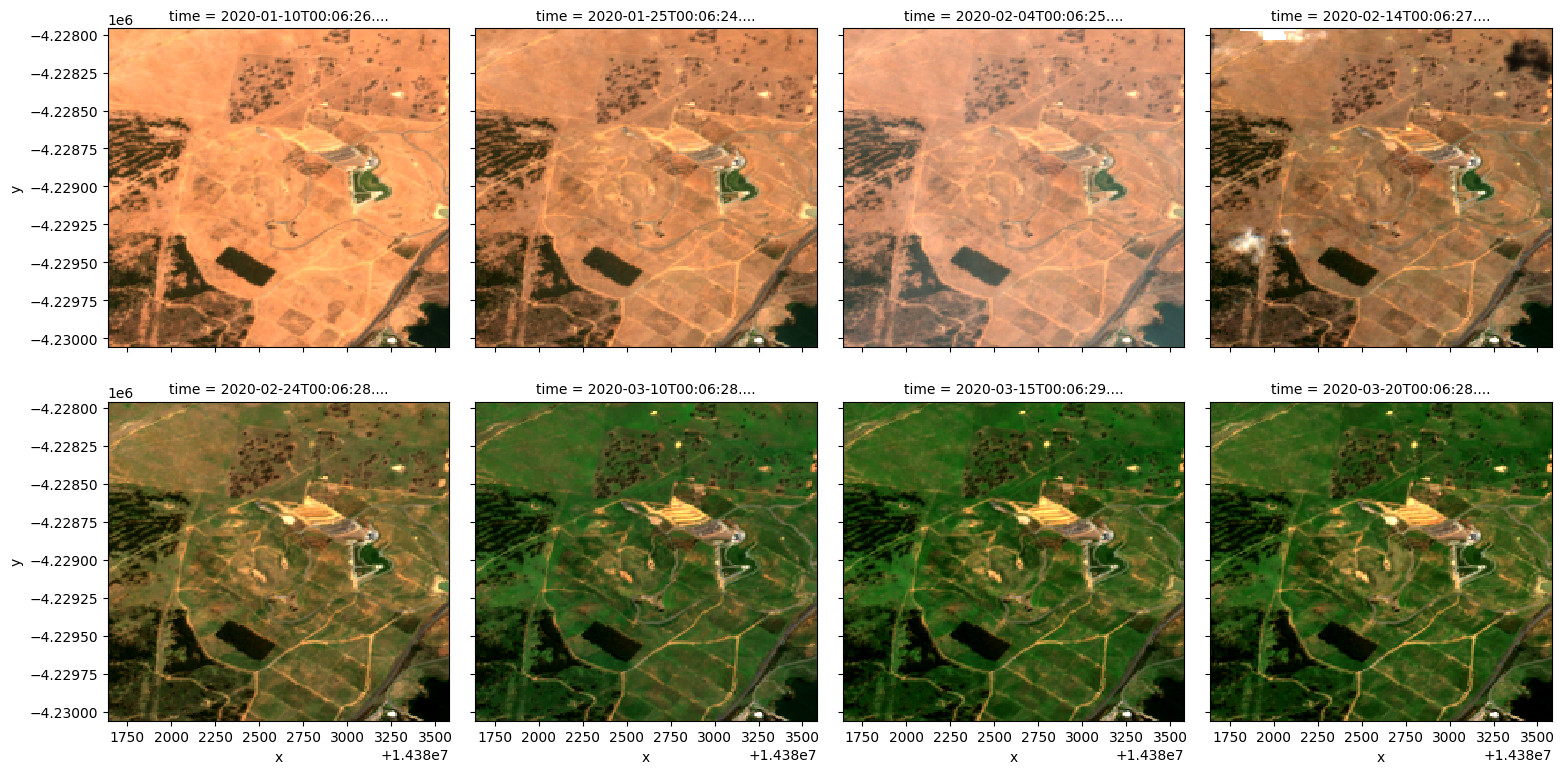

In [59]:
rgb(ds_updated, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    robust = True, 
    size = 4,
    col="time", 
    #col_wrap=36,  # 10-day
    col_wrap=4)

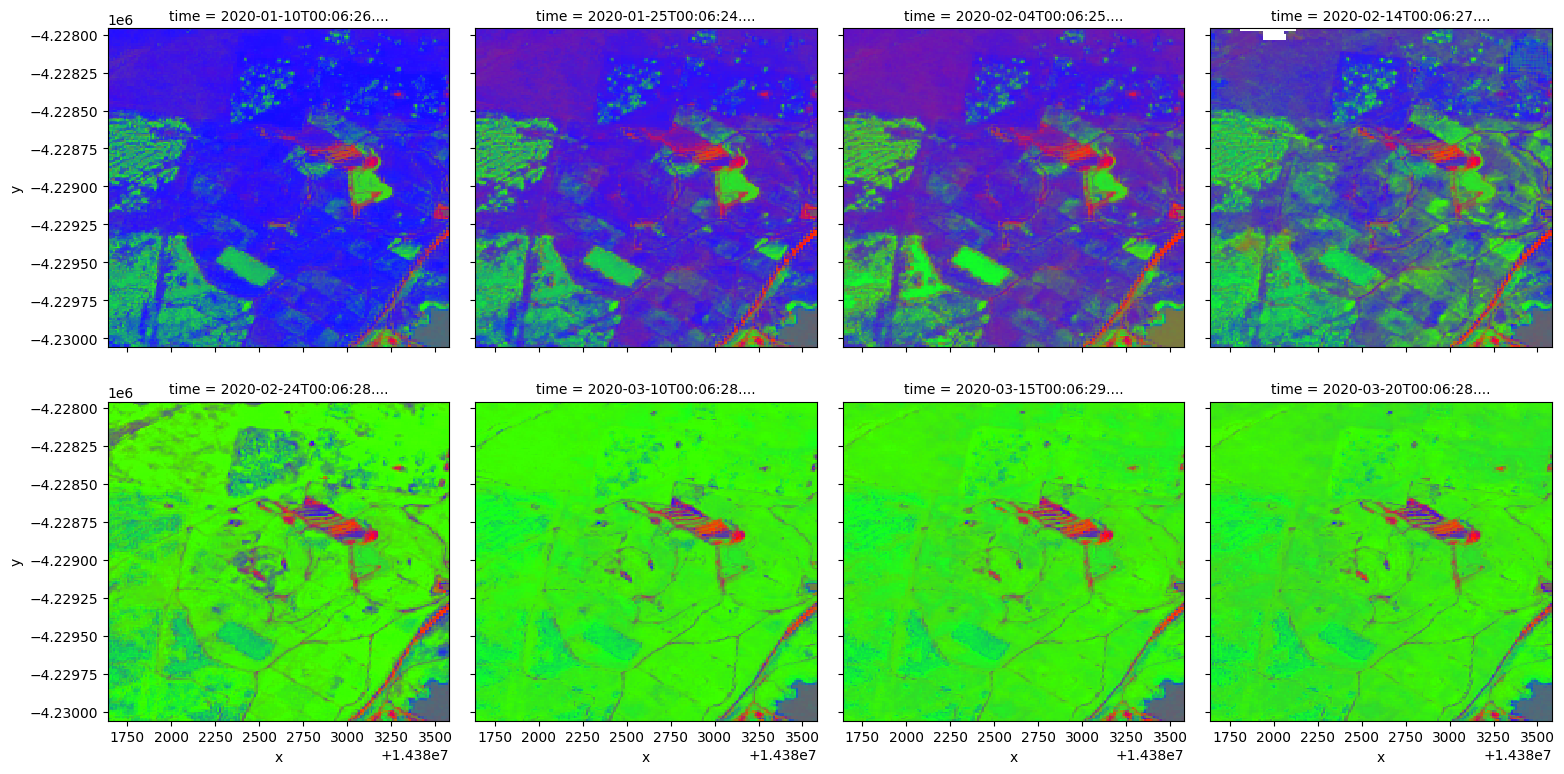

In [61]:
rgb(ds_updated, 
    bands=['bg', 'pv', 'npv'], 
    robust = True, 
    size = 4,
    col="time", 
    #col_wrap=36,  # 10-day
    col_wrap=4)

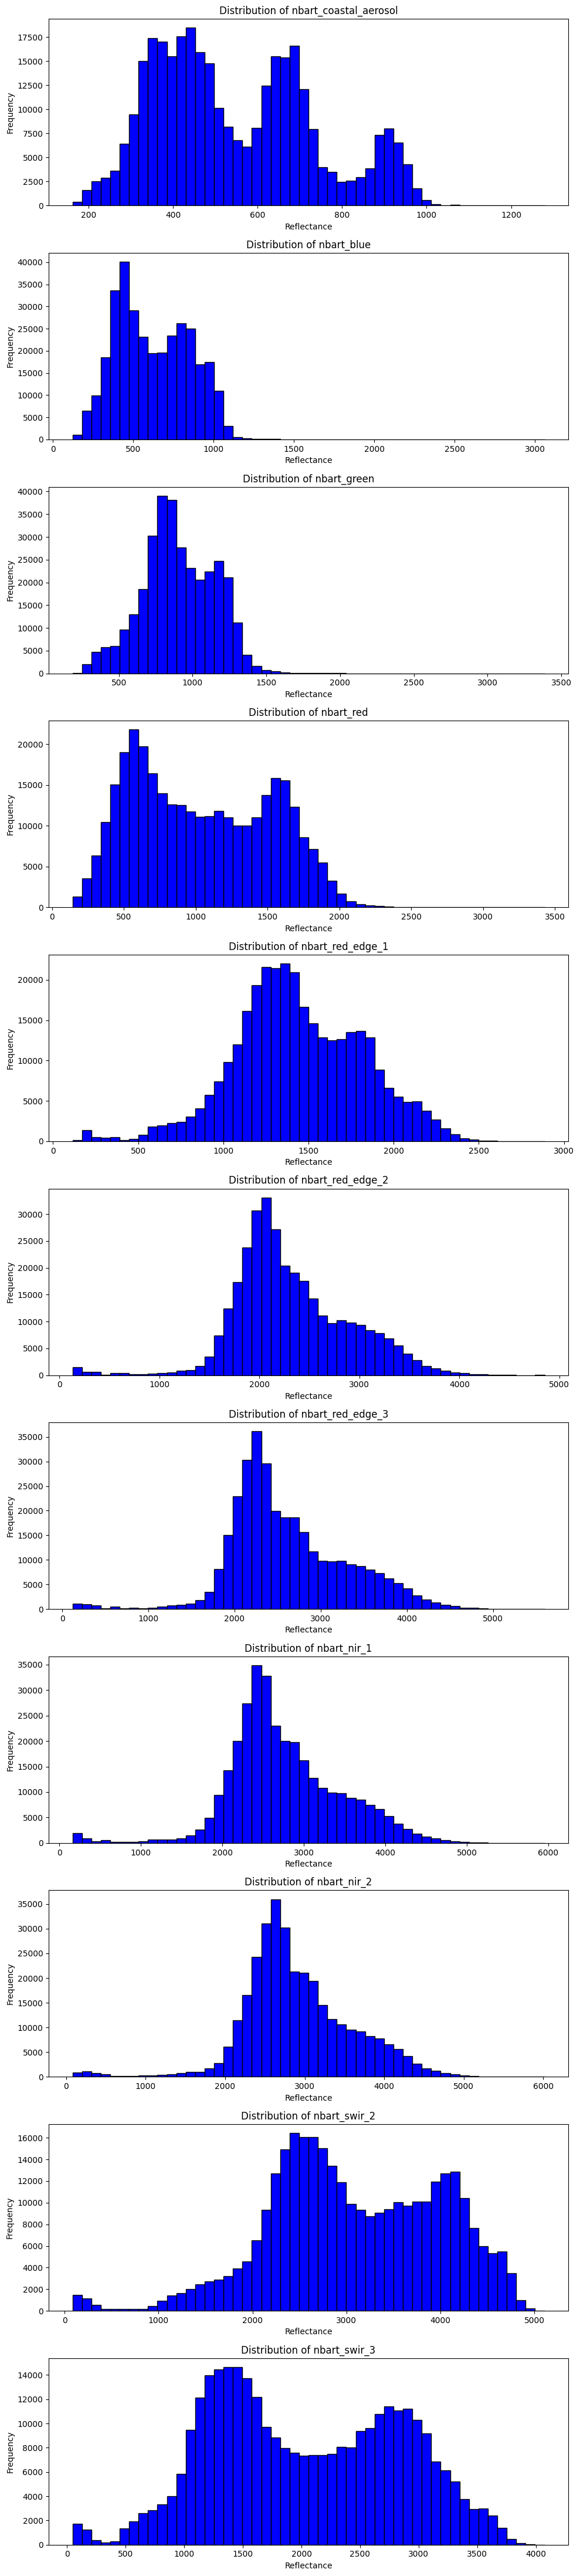

In [17]:
#### Which bands to use?
# start by plotting the distributino of each. 

def plot_band_distributions(ds, band_names):
    """
    Plot the distribution of each specified Sentinel band in the xarray Dataset.

    Parameters:
    ds (xarray.Dataset): The input xarray Dataset containing the satellite data.
    band_names (list): A list of band names to plot the distributions for.
    """
    # Check if the band names are provided
    if not band_names:
        raise ValueError("Band names must be provided")
    
    # Set up the plot
    num_bands = len(band_names)
    fig, axes = plt.subplots(nrows=num_bands, ncols=1, figsize=(10, num_bands * 4))
    
    if num_bands == 1:
        axes = [axes]  # Ensure axes is iterable even if there's only one plot
    
    for ax, band in zip(axes, band_names):
        data = ds[band].values.flatten()  # Flatten the 2D/3D array to 1D
        ax.hist(data, bins=50, color='blue', edgecolor='black')
        ax.set_title(f'Distribution of {band}')
        ax.set_xlabel('Reflectance')
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Example usage
band_names = list(ds.data_vars)[0:11]
plot_band_distributions(ds, band_names)
